# Assignment 4
Submitted By: Jagmeet Singh

**Problem Formulation**

The problem is to predict the price of an Airbnb listing based on the image and the description provided about the listing. Instead of predicting a fixed price for the listing, the problem is formulated to give a range of price defined by three categories namely: beginner, plus, and premium. The data contains listing of areas of Montreal for 2019. 

Multi-task and multi-modality method will be used to predict the type and price range of the listing.

**Data Description**

The data is in the form of text and images. Each listing has an image and respective text summary. The training data consists of image and text summary with the label values for type and price range of the listing. The test data consists of image and summary data for each listing.

**Methods Used**

As the data comes in two different formats, a multi-task model is build. First step includes preprocessing and cleaning the data. For image data is tackled using convolutional neural network and the text data is processed using embedding and GRU/LSTM layers. Attention mechanism is also applied for better results.

In [ ]:
#Mounting google drive to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing libraries
import os

import pandas as pd
from tqdm.notebook import tqdm   #progress bar
from PIL import Image   #image processing
import numpy as np

#importing data from drive
xy_train_df = pd.read_csv('drive/My Drive/CISC873/A4/train_xy.csv') #training data
x_test_df = pd.read_csv('drive/My Drive/CISC873/A4/test_x.csv')     #test data

In [ ]:
#method to load images
#loading the images and converting the images to arrays with size(64,64,2)

def load_image(file):
    try:
        file = 'drive/My Drive/CISC873/A4/img_train/'+file
        #print(file)
        image = Image.open(
            file
        ).convert('LA').resize((64, 64))   #opening image given in file and converting to tensor(64,64,2)
        arr = np.array(image)              #converting to numpy array
        #print('Done')
    except:
        arr = np.zeros((64, 64, 2))        #empty array in case of error in above try
    return arr                             #method returns the array

In [ ]:
# loading images:
x_image = np.array([load_image(i) for i in tqdm(xy_train_df.image)])

# loading summary: (force convert some of the non-string cell to string)
x_text = xy_train_df.summary.astype('str')

In [ ]:
np.shape(x_image[0])

(64, 64, 2)

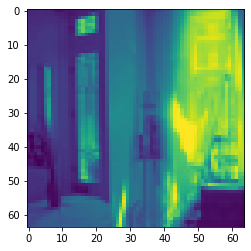

In [ ]:
#displaying one image
from matplotlib import pyplot as plt
plt.imshow(x_image[300][:,:,0])
plt.show()

In [ ]:
#checking total shape of training data
np.shape(x_image)

(7627, 64, 64, 2)

In [ ]:
np.shape(x_text)

(7627,)

In [ ]:
#train validation splitting
from sklearn.model_selection import train_test_split

# labels:
y_price = xy_train_df.price   #label for price category
y_type = xy_train_df.type.astype('category').cat.codes   #label for listing category

len_price = len(y_price.unique())  #number of unique price categories
len_type = len(y_type.unique())    #number of unique listing category

#print the unique numbers
print('unique values for price category', len_price, y_price.unique())
print('unique values for type category', len_type, y_type.unique())



unique values for price category 3 [1 0 2]
unique values for type category 24 [ 1 17 22 10 18 20  5  2  8  4 23 13 15 16 14 11 19  0 21  3  6 12  7  9]


* The different categories for price are 3 as described.
* The different categories for listing type are 24.

In [ ]:
#train and validation splitting 

x_tr_image, x_vl_image, x_tr_text, x_vl_text, y_tr_price, y_vl_price, y_tr_type, y_vl_type = train_test_split(
    x_image, 
    x_text,
    y_price,
    y_type,
    test_size=0.2)

#printing shape of each array formed
print(np.shape(x_tr_image))
print(np.shape(x_vl_image))
print(np.shape(y_tr_price))
print(np.shape(y_vl_price))
print(np.shape(y_tr_type))
print(np.shape(y_vl_type))

(6101, 64, 64, 2)
(1526, 64, 64, 2)
(6101,)
(1526,)
(6101,)
(1526,)


In [ ]:
#Text data preprocessing

from tensorflow.keras.preprocessing.text import Tokenizer  #Tokenizer library to give each word a token 
from tensorflow.keras.preprocessing.sequence import pad_sequences #To convert tokenized array to a 2D array
from sklearn.model_selection import train_test_split  # to make train-validation split
from pprint import pprint

vocab_size = 40000  #defining vocabulary size
max_len = 100       #defining max length of the array for each sequence


# build vocabulary from training set
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_tr_text)  #vocab based on words in training data


#Method which assigns integer value to each word in the sequence based on vocabulary 
#and then transforms into a matrix using pad_sequences

#pad_sequences transforms a list of sequences 
#into a 2D Numpy array of shape (num_samples, num_timesteps).
def _preprocess(list_of_text):
    return pad_sequences(
        tokenizer.texts_to_sequences(list_of_text), #transforms each text in texts to sequence of integers
        maxlen=max_len,  #maximum length of all sequences
        padding='post',  #specifying padding after sequence
    )

* Each sequence (summary text) is converted to array of size 100 based on the vocabulary

In [ ]:
# padding is done inside: 
#preprocessing train and validation text data
x_tr_text_id = _preprocess(x_tr_text)
x_vl_text_id = _preprocess(x_vl_text)

#printing shape after preprocessing
print(x_tr_text_id.shape)
print(x_vl_text_id.shape)

(6101, 100)
(1526, 100)


In [ ]:
print(np.shape(x_tr_text_id[0]))
x_tr_text_id[0]

(100,)


array([  72,  137,  128,  156,    5,    3,  116,   77,   38,    4,    1,
        496,  524,  830,  348, 1748,  502,   54,   90,    3,  610,  234,
       1060, 1344,  409,  753,  165,  335,  753,    8,  216, 1188,    5,
          1,  119,   11,  409, 1539,  880,   11, 1284, 1539, 2402,  194,
       5239,   52,   30, 1498,  144,    8,   74,  146,  133,   68,    2,
         74,  422,  275,   68,   54,   90,  182,  358,  238,  577,  172,
       1634, 1231, 1812, 3341,  119,  291,  578,    2,  703,  208,   13,
          3,  224,   47,  124,  341,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [ ]:
#converting the preprocessing sequence back to text
pprint(tokenizer.sequences_to_texts(x_tr_text_id[0:1]))

['beautiful modern new studio in a great location close to the olympic stadium '
 'botanical garden nicely decorated it has a really good vibe important long '
 'term only short term is not allowed in the building à long terme seulement à '
 "court terme n'est pas autorisé dans le bâtiment there is one comfortable "
 'queen bed and one single sofa bed it has high speed internet smart tv 4k '
 'elevator sound proof building air conditioning and heating ideal for a '
 'couple or two friends']


In [ ]:
#no. of vocab words
print('total words in the dictionary:', tokenizer.num_words)

total words in the dictionary: 40000


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import collections
import matplotlib.pyplot as plt #for plotting 
import numpy as np
import tensorflow as tf   
from tensorflow import keras

#importing layers
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.optimizers import Adam #optimizer

In [ ]:
#specifying input layers
in_text = keras.Input(batch_shape=(None, max_len))  #for text data input layer shape is (batch, max_length)
in_image = keras.Input(batch_shape=(None, 64, 64, 2))  #for image data input layer shape (batch, 64,64,2)


# text part
#embedding-> Each array element is embedded as an array 
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) #embedding layer Output Shape: (None, 100, 100)
averaged = tf.reduce_mean(embedded, axis=1) #averaging embedding layer Output Shape:[(None, 100)]


# image part
cov = Conv2D(32, (16, 16))(in_image) #2D Convolutional layer with 32 filters and filter size of 16x16, Output: (None, 49, 49, 32)
pl = MaxPool2D((16, 16))(cov)        #Maximum pool layer Output Shape: (None, 3, 3, 32)
flattened = Flatten()(pl)            #flattening layer Output Shape (None, 288)


# fusion:
fused = tf.concat([averaged, flattened], axis=-1) #concatenating both image and text data Output Shape: [(None, 388)]

# multi-objectives (each is a multi-class classification) final layers
p_price = Dense(len_price, activation='softmax', name='price')(fused) #for price category Output shape: (None, 3)
p_type = Dense(len_type, activation='softmax', name='type')(fused)    #for type category Output Shape: (None, 24)

In [ ]:
#Building the model
#inputs are text and image data
#outputs are price range category and type category

model = keras.Model(
    inputs={                         #specifying inputs
        'summary': in_text,
        'image': in_image
    },
    outputs={                      #specifying outputs
        'price': p_price,
        'type': p_type,
    },
)


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 2)]  0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 49, 32)   16416       input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     4000000     input_1[0][0]                    
_______________________________________________________________________________________

In [ ]:
#compiling the model
#specifying optimizer loss metrices


model.compile(
    optimizer=Adam(),
    loss={
        'price': 'sparse_categorical_crossentropy',
        'type': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'price': 0.5,
        'type': 0.5,       
    },
    metrics={
        'price': ['SparseCategoricalAccuracy'],
        'type': ['SparseCategoricalAccuracy'],
    },
)


In [ ]:
#training the model
history = model.fit(
    x={
        'summary': x_tr_text_id,
        'image': x_tr_image
    },
    y={
        'price': y_tr_price,
        'type': y_tr_type,
    },
    epochs=20,
    batch_size=16,
    validation_data=(
        {
            'summary': x_vl_text_id,
            'image': x_vl_image
         }, 
        {
            'price': y_vl_price,
            'type': y_vl_type,
        }),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, ) #Callback for early stopping
    ],
    verbose=1
)

Epoch 1/20
382/382 [==============================] - 70s 184ms/step - loss: 23.2829 - price_loss: 16.7395 - type_loss: 29.8262 - price_sparse_categorical_accuracy: 0.5040 - type_sparse_categorical_accuracy: 0.5835 - val_loss: 9.5159 - val_price_loss: 5.5714 - val_type_loss: 13.4604 - val_price_sparse_categorical_accuracy: 0.4653 - val_type_sparse_categorical_accuracy: 0.2975
Epoch 2/20
382/382 [==============================] - 70s 182ms/step - loss: 7.1408 - price_loss: 5.2009 - type_loss: 9.0808 - price_sparse_categorical_accuracy: 0.5224 - type_sparse_categorical_accuracy: 0.5894 - val_loss: 5.4603 - val_price_loss: 4.6177 - val_type_loss: 6.3030 - val_price_sparse_categorical_accuracy: 0.5505 - val_type_sparse_categorical_accuracy: 0.6776
Epoch 3/20
382/382 [==============================] - 69s 182ms/step - loss: 5.7192 - price_loss: 4.3085 - type_loss: 7.1299 - price_sparse_categorical_accuracy: 0.5371 - type_sparse_categorical_accuracy: 0.6030 - val_loss: 8.8170 - val_price_los

In [ ]:
x_test_summary = _preprocess(x_test_df.summary.astype(str))
x_test_image = np.array([load_image(i) for i in tqdm(x_test_df.image)])

In [ ]:
#predicting the values for test data
y_predict = model.predict(
    {
        'summary': x_test_summary,
        'image': x_test_image
    }
)

price_predicted = y_predict['price'] #predicted price
print(price_predicted)

#converting the array as one number (0,1,2)
price_category_predicted = np.argmax(price_predicted, axis=1) #category predictor
print(price_category_predicted)

#making csv file
pd.DataFrame(
    {'id': x_test_df.id,
     'price': price_category_predicted}).to_csv('sample_submission.csv', index=False)

[[2.3369102e-02 4.4228843e-01 5.3434247e-01]
 [9.9923074e-01 6.2977883e-04 1.3944837e-04]
 [9.9322587e-01 6.1475988e-03 6.2647433e-04]
 ...
 [2.2346729e-01 7.2570121e-01 5.0831564e-02]
 [9.9708706e-01 2.5612807e-03 3.5165710e-04]
 [3.7219042e-01 5.9931797e-01 2.8491611e-02]]
[2 0 0 ... 1 0 1]


# Adding Sentence Piece, Bi-GRU, CNN and Attention

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import collections
import matplotlib.pyplot as plt #for plotting 
import numpy as np
import tensorflow as tf   
from tensorflow import keras

#importing layers
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.optimizers import Adam #optimizer

In [ ]:
#Text data preprocessing

from tensorflow.keras.preprocessing.text import Tokenizer  #Tokenizer library to give each word a token 
from tensorflow.keras.preprocessing.sequence import pad_sequences #To convert tokenized array to a 2D array
from sklearn.model_selection import train_test_split  # to make train-validation split
from pprint import pprint
from keras.layers import GRU

In [ ]:
pip install sentencepiece

In [ ]:
import sentencepiece as spm

In [ ]:
#converting all train text + validation text to numpy array
text_array = np.array(x_text)

In [ ]:
#saving array as .txt file
np.savetxt('train_txt.txt',text_array,fmt="%s")
#training tokenizer over training text data
spm.SentencePieceTrainer.train(input='train_txt.txt', model_prefix='m', vocab_size=14507) 

sp = spm.SentencePieceProcessor(model_file='m.model')

In [ ]:
max_len = 200 #maximum length of array for each sentence

In [ ]:
sp.vocab_size() #vocabulary size of tokenizer

14507

In [ ]:
#testing the tokenizer encoding
sp.encode('This is a test')

[87, 8, 15, 7, 126, 227]

In [ ]:
#decoding the array
sp.decode([87, 8, 15, 7, 126, 227])

'This is a test'

In [ ]:
#pad_sequences transforms a list of sequences 
#into a 2D Numpy array of shape (num_samples, num_timesteps).
def _preprocess(list_of_text):
    encoded = []                     #empty array to store encoded sentences
    for text in list_of_text:        #loop for each sentence array
      encoded.append(sp.encode(text))  #encoding the sentence
    return pad_sequences(
        encoded, 
        maxlen=max_len,  #maximum length of all sequences
        padding='post',  #specifying padding after sequence
    )

In [ ]:
# padding is done inside: 
#preprocessing train and validation text data
x_tr_text_id = _preprocess(x_tr_text)
x_vl_text_id = _preprocess(x_vl_text)

#printing shape after preprocessing
print(x_tr_text_id.shape)
print(x_vl_text_id.shape)

(6101, 200)
(1526, 200)


In [ ]:
#checking the encoded sequence
x_tr_text_id[0]

array([ 106, 1034, 1737,    7,  849,  184,   82,   38,   10,    7,  175,
         24,   39,    7,  144,   44,   20,    6,   36,   25, 2697,  121,
       4354,  122,  837,    6,   36,  250,   20,    6,   24,   88,   34,
         24,   15, 1472,   39,   10,    6,   79,   61,   11,   78,  148,
        395,   53,  298,    3,   70,    3,    5,   30,    4,   87,   18,
          9,  246,  132,   36,  299,   44,   20, 1665,   23,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [ ]:
#decoding the sequence
sp.decode([ 106, 1034, 1737,    7,  849,  184,   82,   38,   10,    7,  175,
         24,   39,    7,  144,   44,   20,    6,   36,   25, 2697,  121,
       4354,  122,  837,    6,   36,  250,   20,    6,   24,   88,   34,
         24,   15, 1472,   39,   10,    6,   79,   61,   11,   78,  148,
        395,   53,  298,    3,   70,    3,    5,   30,    4,   87,   18,
          9,  246,  132,   36,  299,   44,   20, 1665,   23,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0])

"I am renting a huge double bed room in a spacious apartment located a minute away from the metro (you can actually see the metro Laurier from the apartment). The apartment is centrally located in the Plateau Mont-Royal near many cafes, bars, and restaurants. It's only 4 metro stations away from Osheaga! ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ "

In [ ]:
#verifying the sequence with the encoded one
np.array(x_tr_text)[0]

"I am renting a huge double bed room in a spacious apartment located a minute away from the metro (you can actually see the metro Laurier from the apartment). The apartment is centrally located in the Plateau Mont-Royal near many cafes, bars, and restaurants. It's only 4 metro stations away from Osheaga!"

In [ ]:
#building the model

#specifying input layers
in_text = keras.Input(batch_shape=(None, max_len))  #for text data input layer shape is [(None, 200)]
in_image = keras.Input(batch_shape=(None, 64, 64, 2))  #for image data input layer shape [(None, 64, 64, 2)]
# text part
#embedding-> Each array element is embedded as an array 
embedded = keras.layers.Embedding(sp.vocab_size(), 200)(in_text) #embedded layer (None, 200, 200) 
gru1 = tf.keras.layers.Bidirectional(GRU(150, dropout=0.1,return_sequences=True))(embedded) #Bidirectional with 50 units, Output Shape: (None, 200, 300)  
#gru2 = tf.keras.layers.Bidirectional(GRU(75, dropout=0.1,return_sequences=True))(gru1)  #(None,200,100)
#fc1 = tf.keras.layers.Dense(150, activation='relu')(gru2)


#implementing Attention Mechanism
query = Dense(200)(tf.expand_dims(gru1[:, -1, :], [1]))  #query as last output of GRU layer (None, 200, 200)
key = Dense(200)(gru1)                    #defining key (None, 200, 200)
value = Dense(200)(gru1)                  #defining value (None, 200, 200)

att_1 = tf.keras.layers.Attention()([query, value,key])  #implementing attention layer
att_1 = tf.squeeze(att_1,[1])                        #removing one dimension 

# image part
drop_1 = tf.keras.layers.Dropout(.1) #dropout layer specification

cov1 = Conv2D(45, (2, 2))(in_image) #2D Convolutional layer with 32 filters and filter size of 16x16 Output:(None, 63, 63, 45)
outputs = drop_1(cov1, training=True) #(None, 63, 63, 45) 
p1 = MaxPool2D((3, 3))(outputs) #(None, 21, 21, 45)
#cov2 = Conv2D(16, (2, 2))(p1)
#p2 = MaxPool2D((2, 2))(cov2)        
flattened = Flatten()(p1)            #flattening layer Output Shape (None, 19845) 
fc2 = tf.keras.layers.Dense(200, activation='relu')(flattened)  #(None, 200)

# fusion:

#fused = tf.concat([att_1, fc2], axis=-1) #concatenating both image and text data Output Shape: [(None, 388)]
fused = tf.reduce_mean([att_1, fc2], axis=0)  #using reduce_mean [(None, 200)]

# multi-objectives (each is a multi-class classification) final layers
p_price = Dense(len_price, activation='softmax', name='price')(fused) #for price category Output shape: (None, 3)
p_type = Dense(len_type, activation='softmax', name='type')(fused)    #for type category Output Shape: (None, 24)

In [ ]:
#Building the model
#inputs are text and image data
#outputs are price range category and type category

model = keras.Model(
    inputs={                         #specifying inputs
        'summary': in_text,
        'image': in_image
    },
    outputs={                      #specifying outputs
        'price': p_price,
        'type': p_type,
    },
)


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 200)     2901400     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 200, 300)     316800      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 2)]  0                                            
_______________________________________________________________________________________

In [ ]:
#compiling the model
#specifying optimizer loss metrices


model.compile(
    optimizer=Adam(),
    loss={
        'price': 'sparse_categorical_crossentropy',
        'type': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'price': 0.5,
        'type': 0.5,       
    },
    metrics={
        'price': ['SparseCategoricalAccuracy'],
        'type': ['SparseCategoricalAccuracy'],
    },
)

In [ ]:
#training the model
#Early stopping implemented using restore best weights
#which keep the best weights among all the epochs

history = model.fit(
    x={
        'summary': x_tr_text_id,
        'image': x_tr_image
    },
    y={
        'price': y_tr_price,
        'type': y_tr_type,
    },
    epochs=7,
    batch_size=16,
    validation_data=(
        {
            'summary': x_vl_text_id,
            'image': x_vl_image
         }, 
        {
            'price': y_vl_price,
            'type': y_vl_type,
        }),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=3, restore_best_weights=True) #Callback for early stopping
    ],
    verbose=1
)

Epoch 1/7
382/382 [==============================] - 244s 638ms/step - loss: 0.5669 - price_loss: 0.5220 - type_loss: 0.6119 - price_sparse_categorical_accuracy: 0.7825 - type_sparse_categorical_accuracy: 0.8253 - val_loss: 0.8360 - val_price_loss: 0.8406 - val_type_loss: 0.8314 - val_price_sparse_categorical_accuracy: 0.6710 - val_type_sparse_categorical_accuracy: 0.7851
Epoch 2/7
382/382 [==============================] - 244s 639ms/step - loss: 0.4683 - price_loss: 0.4330 - type_loss: 0.5036 - price_sparse_categorical_accuracy: 0.8228 - type_sparse_categorical_accuracy: 0.8559 - val_loss: 0.8860 - val_price_loss: 0.8467 - val_type_loss: 0.9253 - val_price_sparse_categorical_accuracy: 0.6678 - val_type_sparse_categorical_accuracy: 0.7877
Epoch 3/7
382/382 [==============================] - 244s 639ms/step - loss: 0.3824 - price_loss: 0.3555 - type_loss: 0.4093 - price_sparse_categorical_accuracy: 0.8617 - type_sparse_categorical_accuracy: 0.8825 - val_loss: 1.0652 - val_price_loss: 1

**The above model is the best that has been obtained till yet after fine tuning all the hyperparameters.**

In [ ]:
 x_test_summary = _preprocess(x_test_df.summary.astype(str))
x_test_image = np.array([load_image(i) for i in tqdm(x_test_df.image)])

In [ ]:
#predicting the values for test data
y_predict = model.predict(
    {
        'summary': x_test_summary,
        'image': x_test_image
    }
)

price_predicted = y_predict['price'] #predicted price
print(price_predicted)

#converting the array as one number (0,1,2)
price_category_predicted = np.argmax(price_predicted, axis=1) #category predictor
print(price_category_predicted)

#making csv file
pd.DataFrame(
    {'id': x_test_df.id,
     'price': price_category_predicted}).to_csv('sub15.csv', index=False)

[[9.8909879e-01 9.8174838e-03 1.0836857e-03]
 [9.9962616e-01 3.6183812e-04 1.1977868e-05]
 [9.7420204e-01 2.1012904e-02 4.7850963e-03]
 ...
 [7.3074865e-01 2.3168249e-01 3.7568931e-02]
 [9.9687648e-01 2.8478603e-03 2.7566223e-04]
 [4.4393906e-01 4.5701787e-01 9.9043071e-02]]
[0 0 0 ... 0 0 1]


# Questions:

### Ques 1: What is multi-objective/multi-task learning? What is multi-modality learning? How this assignment fits into those paradigm?

Ans: In single objective learning, a specific task is being optimized to get the best model. But in some cases, it becomes important to incorporate related task data to get better results and the method is called as multi-objective/multi-task learning. By sharing information of related task, the model becomes more generalizable and better trained. As in this assignment, the hidden layers are shared between two tasks and the final layer is the task specific layer. This approach is also termed as hard-parameter sharing.

**Multi-modality**: Multi-modality traning includes using different kinds of information to train the model. As given in this assignment, the image data and text data information is used to get the required result. The image data information is extracted using Convolutional Neural Network while the text data information is extracted using GRU layer and then finally both the information is combined.

In this assignment, we are using multi-task and multi-modality. Here information is combined from two different task (predicting price range and predicting type category) and the two tasks has information in different type: image and text. Thus it is both mutli-task and multi-modality.

### Ques 2: How attention mechanism can help with the learning process?

Ans: Attention Mechanism give us score for each feature given in the data. The score is based upon how important that feature is for the model. By having information about the importance of the features, some heavy weights are assign to that feature in the attention mechanism. This helps in getting more good model as some features (words in this case) impact model more than others. This is very helpful in Natural Language processing as there are many words that carry more information than others.

### Ques 3: In the template, we use early stopping. What is the purpose? Try to set restore_best_weights to True.

Ans: Early Stopping is used to monitor the training of the model. A monitor metric and patience level is specified in the early stopping initialization. Early stopping monitor corresponding metric after each epoch and if the metric values perform badly regularly beyond the patience level, the training is stopped. Thus, early stopping is used to monitor the training and stopping the training if the model is being trained badly.

restor_best_weights keeps track of the best model weights. If it is False, only the last epoch weights are used while using it as 'True' makes it use the weights which is best according to the monitor metric.

### Ques 4: Compared to the original tokenizer, what is the advantage of sub-word tokenizers such as sentencepiece ?

Ans: The original tokenizer is based on splitting the sentence into words based on spaces and then tokenizing the sentence based on words splitted away. This is the simplest way of tokenizing the sentences, but this method is not that accurate in many cases. This method fails to incorporate the words that are not exactly same as in the vocabulary. There can be mistakes while writing the text and many other complications which are not incorpoated by given tokenizer.

A possible good tokenizer is sub-word tokenizers which is based on that most common words are left as same and the rare words are splitted into meaningful subword units. This method is helpful in many languages other than English. This also enables the model to process words it has never seen before, by decomposing them into subwords it knows. Sentence piece tokenizer is more good to work with languages which don't uses spaces to separate words. Sentence piece also includes the spaces and treat input as raw input and then the appropriate vocabulary is being built.

# References

* https://towardsdatascience.com/multimodal-deep-learning-ce7d1d994f4
* https://huggingface.co/transformers/tokenizer_summary.html
* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
* https://github.com/google/sentencepiece/tree/master/python
* https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
* https://ruder.io/multi-task/
* https://towardsdatascience.com/intuitive-understanding-of-attention-mechanism-in-deep-learning-6c9482aecf4f